In [1]:
from pyrpe.src.quapack.pyRPE import RobustPhaseEstimation
from pyrpe.src.quapack.pyRPE.quantum import Q
import numpy as np
import pygsti
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
from pygsti.modelpacks import smq2Q_XYZICNOT

In [10]:
def make_cos_circ(k):
    return (pygsti.circuits.Circuit([[('Gxpi2',0)]])*2+
            pygsti.circuits.Circuit([[('Gcr',0,1)]])*k+
            pygsti.circuits.Circuit([[('Gxpi2',0)]])*2)

def make_sin_circ(k):
    return (pygsti.circuits.Circuit([[('Gxpi2',0)]])*2+
            pygsti.circuits.Circuit([[('Gcr',0,1)]])*k+
            pygsti.circuits.Circuit([[('Gxpi2',0)]])*2+
            pygsti.circuits.Circuit([[('Gzpi2',1)]])*2+
            pygsti.circuits.Circuit([[('Gxpi2',1)]])*3)

In [11]:
max_depths = [1,2,4,8,16,32]
#Can go shallower or deeper; chose 32 somewhat arbitrarily for this demo.  
#The deeper we can go, the better (up to depolarization).
#The total number of circuits required is 2*len(max_depths)

In [12]:
sin_dict = {i: make_sin_circ(i) for i in max_depths}
cos_dict = {i: make_cos_circ(i) for i in max_depths}

circ_dict = {'sin':sin_dict,'cos':cos_dict}

all_circs = list(sin_dict.values()) + list(cos_dict.values())

In [13]:
target_model = smq2Q_XYZICNOT.target_model()

In [14]:
#Make the unitary cross-resonance gate.  Target angle is pi/2.
def ZX(theta):
    return scipy.linalg.expm(-1j/2 * theta * pygsti.sigmazx)

In [15]:
#Make a noisy model
noisy_model_0 = target_model.copy()
delta = 0.1
noisy_model_0['Gcr',0,1] = pygsti.unitary_to_pauligate(ZX(np.pi/2+delta))

In [16]:
#Make an RPE dataset with the noisy model
dataset_0 = pygsti.data.simulate_data(noisy_model_0,all_circs,100)

/home/jpmarceaux/.local/lib/python3.10/site-packages/pygsti/layouts/evaltree.py:183: UserWarning: Created an evaluation tree that is inefficient: tree-size > 3 * #circuits !
This is likely due to the fact that the circuits being simulated do not have a
periodic structure. Consider using a different forward simulator (e.g. MapForwardSimulator).
  _warnings.warn(("Created an evaluation tree that is inefficient: tree-size > %d * #circuits !\n"


In [17]:
#Post-process the RPE data from the pyGSTi dataset
the_experiment = Q()
for i in max_depths:
    the_experiment.process_sin(i,(int(dataset_0[sin_dict[i]]['00']),int(dataset_0[sin_dict[i]]['01'])))
    the_experiment.process_cos(i,(int(dataset_0[cos_dict[i]]['00']),int(dataset_0[cos_dict[i]]['01'])))

In [18]:
#Run RPE
rpe = RobustPhaseEstimation(the_experiment)

In [19]:
#Look at the successive estimates of the RPE routine
rpe.angle_estimates

array([1.49096634, 1.65012396, 1.68024415, 1.67554398, 1.66647243,
       1.67573829])

Text(0, 0.5, 'Angle estimate error')

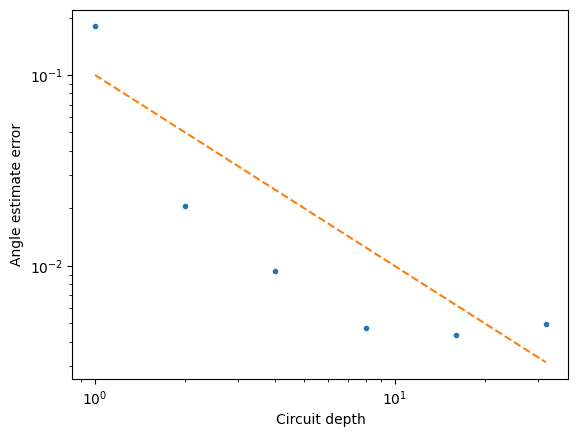

In [20]:
#Sanity check- does the error in the angle estimate decrease as 1/circuit depth?
plt.plot(max_depths,np.abs(rpe.angle_estimates - (np.pi/2 + delta)),'.')
plt.plot(max_depths,.1/np.array(max_depths),'--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Circuit depth')
plt.ylabel('Angle estimate error')

In [21]:
#Extract the last "trusted" RPE angle estimate.  This is the quantity that will get fed to the optimizer.
#For the cross-resonance gate, the target is pi/2.
last_good_estimate_generation = rpe.check_unif_local(historical=True)
angle_estimate = rpe.angle_estimates[last_good_estimate_generation]

In [22]:
print('Angle estimate is', angle_estimate, 'radians')
print('Error in angle estimate is', abs(angle_estimate - (np.pi/2 + delta)),'radians')

Angle estimate is 1.6757382942500805 radians
Error in angle estimate is 0.004941967455183827 radians
